#XLNet4Rec - Movielense 1M

#### References: 
<br> 1) Tokenization and embedding
* https://medium.com/huggingface/how-to-build-a-state-of-the-art-conversational-ai-with-transfer-learning-2d818ac26313
* https://reyfarhan.com/posts/easy-gpt2-finetuning-huggingface/

<br> 2) Training and Testing
* https://mccormickml.com/2019/09/19/XLNet-fine-tuning/
* https://towardsdatascience.com/teaching-gpt-2-a-sense-of-humor-fine-tuning-large-transformer-models-on-a-single-gpu-in-pytorch-59e8cec40912
* https://huggingface.co/transformers/model_doc/xlnet.html

<br> 3) Evaluation
* https://github.com/FeiSun/BERT4Rec

# Setup

In [ ]:
# Install transformers
!pip install transformers

In [2]:
# Import libraries
import os
import io
import pickle
import time
import datetime
import random
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

import sklearn
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)
from tqdm import tqdm, trange

from transformers import BertTokenizer, XLNetTokenizer, XLNetConfig, XLNetModel, XLNetLMHeadModel 
from transformers import AdamW, get_linear_schedule_with_warmup

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
ratings_frame = pd.read_csv(F"/content/gdrive/My Drive/ML_1m/ratings.dat", names=["userId", "movieId", "rating", "timestamp"], sep="::", engine="python")

In [5]:
ratings_frame.movieId = ratings_frame.movieId.apply(str)

In [6]:
# Find users with more than 5 ratings
idlist = ratings_frame['userId'].value_counts()
indexes = idlist[idlist >= 5].index

In [7]:
# Extract Popular items
pdlist = ratings_frame['movieId'].value_counts()

In [8]:
# Combine users and ratings as a list
ratings_subset = ratings_frame[ratings_frame['userId'].isin(indexes)]
ratings_subset.sort_values(by=['userId', 'timestamp'], inplace = True)
ratings_final = ratings_subset.groupby('userId')['movieId'].apply(list).reset_index(name='items')

In [9]:
ratings_final

,userId,items
0,1,"[3186, 1270, 1721, 1022, 2340, 1836, 3408, 280..."
1,2,"[1198, 1210, 1217, 2717, 1293, 2943, 1225, 119..."
2,3,"[593, 2858, 3534, 1968, 1431, 1961, 1266, 1378..."
3,4,"[1210, 1097, 3468, 480, 3527, 260, 1196, 1198,..."
4,5,"[2717, 908, 919, 1250, 356, 2858, 1127, 2188, ..."
...,...,...
6035,6036,"[1721, 2428, 3438, 1883, 2376, 2492, 2826, 282..."
6036,6037,"[1882, 3508, 702, 1267, 2028, 3148, 858, 562, ..."
6037,6038,"[920, 3396, 1210, 2146, 356, 1387, 1079, 1148,..."
6038,6039,"[282, 111, 2067, 930, 1230, 3022, 947, 3088, 3..."


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


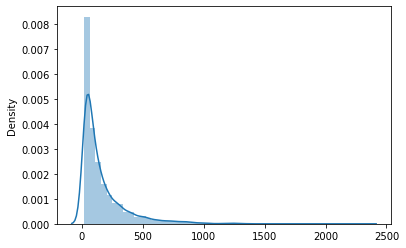

In [10]:
# Check length of items per user
import seaborn as sns

item_lengths = []

for r in range(0,len(ratings_final['items'])):

    # get rough token count distribution
    item_lengths.append(len(ratings_final['items'][r]))

doc_lengths = np.array(item_lengths)

sns.distplot(item_lengths)

In [11]:
# Maximum length of items
np.max(item_lengths)

2314

In [12]:
# Median length of items
np.mean(item_lengths)

165.5975165562914

In [13]:
# Length of final dataset
len(ratings_final)

6040

In [14]:
# Create new tokens
from itertools import chain
#new_tokens = list(set(list(chain(*ratings_final['items']))))
new_tokens = list(pdlist.index)
#new_tokens = ['<unk>','<s>','</s>','<cls>','<sep>','<pad>','<mask>','<eod>','<eop>'] + new_tokens
new_tokens = ['<unk>','<mask>','<pad>','<cls>','<sep>'] + new_tokens

In [15]:
# Length of new tokens
len(new_tokens)

3711

In [16]:
# Create vocab list for tokenizer
with open('vocab.txt', 'w') as f:
    for item in new_tokens:
        f.write("%s\n" % item)

# Dataset Preparation

In [17]:
# Tokenizer
tokenizer = BertTokenizer(vocab_file='vocab.txt', unk_token='<unk>', do_lower_case=False)

In [18]:
# Padding function
max_length=200
# Now we can pad reply and distractor inputs and targets to the same length
def pad(x, padding):
    return x + [padding] * (max_length - len(x))

In [19]:
# Prepare item seq and padding function
item_seq = ratings_final['items']
train = []
val = []
test = []

for i in range(0,len(item_seq)):
  if len(item_seq[i]) > max_length:
    seq = item_seq[i][0:max_length]
  else:
    seq = item_seq[i]
  train.append(seq[0:-2])
  val.append(seq[0:-1])
  test.append(seq)

In [20]:
# Class for creating dataset
class XLNetDataset(Dataset):

  def __init__(self, item_seq, tokenizer, max_length=50):
    self.tokenizer = tokenizer
    self.input_ids = []
    self.lables = []
    #self.perm_mask = []
    self.target_mapping = []
    
    for seq in item_seq: 
      if len(seq) == max_length:
        seq = seq[0:-2]
      elif len(seq) == (max_length-1):
        seq = seq[0:-1]
      else:
        seq = seq
      tokens = seq + ['<sep>'] + ['<cls>'] 

      # words token
      input_words = tokenizer.convert_tokens_to_ids(tokens)
      input_words = pad(input_words, 2)
      words = torch.tensor(input_words, dtype=torch.long)
      assert len(words) == max_length

      # lables
      lables = words[torch.where(words == 4)[0]-1]
      self.lables.append(lables)

      '''
      # perm_mask
      perm_mask = torch.zeros((1, words.shape[0], words.shape[0]), dtype=torch.long)
      perm_mask[:, :, torch.where(words == 4)[0]-1] = 1
      self.perm_mask.append(perm_mask[0])
      '''
      # target mapping
      target_mapping = torch.zeros((1, 1, words.shape[0]), dtype=torch.float)
      target_mapping[0, 0, torch.where(words == 4)[0]-1] = 1
      self.target_mapping.append(target_mapping[0])

      # masking
      words[torch.where(words == 4)[0]-1] = 1
      self.input_ids.append(words)

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.lables[idx], self.target_mapping[idx], #self.perm_mask[idx], 

In [21]:
# Create Dataset
#dataset = XLNetDataset(item_seq, tokenizer, max_length=200)
train_dataset = XLNetDataset(train, tokenizer, max_length=200)
val_dataset = XLNetDataset(val, tokenizer, max_length=200)
test_dataset = XLNetDataset(test, tokenizer, max_length=200)

# Training

In [22]:
batch_size = 2

# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = SequentialSampler(train_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = 1 # Evaluate with this batch size.
        )

# Test
test_dataloader = DataLoader(
            test_dataset, # The test samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [23]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

In [24]:
config = XLNetConfig(
    vocab_size=3711
)

In [25]:
model = XLNetLMHeadModel(config=config)

In [26]:
BATCH_SIZE = 2
EPOCHS = 1
LEARNING_RATE = 1e-4
WARMUP_STEPS = 100
MAX_SEQ_LEN = 200
total_steps = len(train_dataloader) * EPOCHS

In [ ]:
%%time
model = model.to(device)
model.train()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=total_steps ,last_epoch = -1)
proc_seq_count = 0
sum_loss = 0.0
batch_count = 0

models_folder = "trained_models"
if not os.path.exists(models_folder):
    os.mkdir(models_folder)

for epoch in range(EPOCHS):
    
    print(f"EPOCH {epoch} started" + '=' * 30)
    
    for idx, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)
        b_target_mapping = batch[2].to(device)
        
        outputs = model(input_ids=b_input_ids, labels=b_labels, target_mapping=b_target_mapping)

        loss, logits = outputs[:2]                        
        loss.backward()
        sum_loss = sum_loss + loss.detach().data
                       
        proc_seq_count = proc_seq_count + 1
        if proc_seq_count == BATCH_SIZE:
            proc_seq_count = 0    
            batch_count += 1
            optimizer.step()
            scheduler.step() 
            optimizer.zero_grad()
            model.zero_grad()

        if batch_count == 100:
            print(f"sum loss {sum_loss}")
            batch_count = 0
            sum_loss = 0.0
    
    # Store the model after each epoch to compare the performance of them
    torch.save(model.state_dict(), os.path.join(models_folder, f"XLNet4Rec_Movie_{epoch}.pt"))

EPOCH 0 started==============================
sum loss 1647.1646728515625
sum loss 1607.5379638671875
sum loss 1614.858154296875
sum loss 1625.7506103515625
sum loss 1628.0137939453125
sum loss 1603.4366455078125
sum loss 1585.4676513671875
sum loss 1571.197021484375
sum loss 1581.832763671875
sum loss 1588.564453125
sum loss 1597.232666015625
sum loss 1605.02880859375
sum loss 1594.077392578125
sum loss 1603.5548095703125
sum loss 1579.5252685546875
CPU times: user 15min 51s, sys: 8min 25s, total: 24min 17s
Wall time: 24min 22s


In [ ]:
model_save_name = 'XLNet4Rec_Movie_1.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

# Another Training

In [ ]:
model_save_name = 'XLNet4Rec_Movie_3.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
%%time
model = model.to(device)
model.train()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=total_steps ,last_epoch = -1)
proc_seq_count = 0
sum_loss = 0.0
batch_count = 0

models_folder = "trained_models"
if not os.path.exists(models_folder):
    os.mkdir(models_folder)

for epoch in range(EPOCHS):
    
    print(f"EPOCH {epoch} started" + '=' * 30)
    
    for idx, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)
        b_target_mapping = batch[2].to(device)
        
        outputs = model(input_ids=b_input_ids, labels=b_labels, target_mapping=b_target_mapping)

        loss, logits = outputs[:2]                        
        loss.backward()
        sum_loss = sum_loss + loss.detach().data
                       
        proc_seq_count = proc_seq_count + 1
        if proc_seq_count == BATCH_SIZE:
            proc_seq_count = 0    
            batch_count += 1
            optimizer.step()
            scheduler.step() 
            optimizer.zero_grad()
            model.zero_grad()

        if batch_count == 100:
            print(f"sum loss {sum_loss}")
            batch_count = 0
            sum_loss = 0.0
    
    # Store the model after each epoch to compare the performance of them
    torch.save(model.state_dict(), os.path.join(models_folder, f"XLNet4Rec_Movie_{epoch}.pt"))

EPOCH 0 started==============================
sum loss 1349.63671875
sum loss 1358.9429931640625
sum loss 1398.4970703125
sum loss 1457.6650390625
sum loss 1507.736083984375
sum loss 1506.5982666015625
sum loss 1501.601318359375
sum loss 1497.4395751953125
sum loss 1507.4842529296875
sum loss 1515.5107421875
sum loss 1569.6192626953125
sum loss 1569.0867919921875
sum loss 1549.2437744140625
sum loss 1534.906982421875
sum loss 1517.400390625
CPU times: user 16min 9s, sys: 7min 41s, total: 23min 51s
Wall time: 23min 57s


In [ ]:
model_save_name = 'XLNet4Rec_Movie_4.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

# Testing

In [27]:
model_save_name = 'XLNet4Rec_Movie_4.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [28]:
# Top products
vocab_size = 3706
topProducts = [0,1,2,3,4] + tokenizer.convert_tokens_to_ids(list(pdlist.index)[0:vocab_size])

In [29]:
# Probability of each items
sum_value = np.sum([x for x in pdlist.values[0:vocab_size]])
probs = [0,0,0,0,0,] + [value / sum_value for value in pdlist.values[0:vocab_size]]

In [30]:
# Negative samples
%%time
np.random.seed(12345)
neg_samples = []
for j in range(0,len(test_dataset)):
  samples = np.random.choice(topProducts, 100, replace=False, p=probs)
  notinTest = [i for i in samples if i not in test_dataset[j][0][0:torch.where(test_dataset[j][0] == 1)[0]].tolist()]
  notinTest = notinTest + test_dataset[j][1].tolist()
  neg_samples.append(notinTest)

CPU times: user 27.6 s, sys: 62.6 ms, total: 27.6 s
Wall time: 27.6 s


In [ ]:
# Compute Lengths
neg_samples_length = []
for i in range(0,len(neg_samples)):
  neg_samples_length.append(len(neg_samples[i]))

print(np.min(neg_samples_length))

71


In [ ]:
%%time
model = model.to(device)
labels = []
results = []

for idx, batch in enumerate(test_dataloader):
    b_input_ids = batch[0].to(device)
    b_labels = batch[1].to(device)
    b_target_mapping = batch[2].to(device)
    
    with torch.no_grad():
      outputs = model(input_ids=b_input_ids, labels=b_labels, target_mapping=b_target_mapping)
      logits = outputs[1]
    
    softmax_logits = torch.softmax(logits[0],dim=1)
    softmax_logits = softmax_logits.detach().cpu().numpy()

    label_ids = b_labels.to('cpu').numpy()
    labels.append(label_ids[0])

    results.append(softmax_logits)

CPU times: user 5min 45s, sys: 2min 32s, total: 8min 17s
Wall time: 8min 18s


# Evaluation

In [ ]:
# Ranking
%%time
tens = []
fives = []
ones = []

for i in range(0,len(results)):
  top_idx = np.argsort(results[i][0][neg_samples[i]])[-10:]
  top_values = [neg_samples[i][e] for e in top_idx]
  top_values.reverse()
  tens.append(top_values)
  fives.append(top_values[0:5])
  ones.append([top_values[0]])

CPU times: user 57.8 ms, sys: 0 ns, total: 57.8 ms
Wall time: 58.6 ms


In [ ]:
# For HitRate
matched_tens = []
matched_fives = []
matched_ones = []

for i in range(0,len(labels)):
  matched_tens.append(labels[i][0] in tens[i])
  matched_fives.append(labels[i][0] in fives[i])
  matched_ones.append(labels[i][0] in ones[i])

In [ ]:
# For HitRate
matched_tens = []
matched_fives = []
matched_ones = []

for i in range(0,len(labels)):
  matched_tens.append(labels[i][0] in tens[i])
  matched_fives.append(labels[i][0] in fives[i])
  matched_ones.append(labels[i][0] in ones[i])

In [ ]:
# HitRate
print('HR@10:', sum(matched_tens)/len(labels))
print('HR@5:', sum(matched_fives)/len(labels))
print('HR@1:', sum(matched_ones)/len(labels))

HR@10: 0.013245033112582781
HR@5: 0.009271523178807948
HR@1: 0.002980132450331126


In [ ]:
# For NDCG
ndcg_tens = []
ndcg_fives = []
ndcg_ones = []

for i in range(0,len(labels)):
  for j in range(0,len(tens[i])):
    if labels[i] == tens[i][j]:
      ndcg_tens.append(1/np.log2(j+2))
    else:
      ndcg_tens.append(0)
  for j in range(0,len(fives[i])):
    if labels[i] == fives[i][j]:
      ndcg_fives.append(1/np.log2(j+2))
    else:
      ndcg_fives.append(0)
  for j in range(0,len(ones[i])):
    if labels[i] == ones[i][j]:
      ndcg_ones.append(1/np.log2(j+2))
    else:
      ndcg_ones.append(0)

In [ ]:
# NDCG
print('NDCG@10:', np.mean(ndcg_tens))
print('NDCG@5:', np.mean(ndcg_fives))
print('NDCG@1:', np.mean(ndcg_ones))

NDCG@10: 0.0007509409774537978
NDCG@5: 0.0012512977524511103
NDCG@1: 0.002980132450331126


In [ ]:
# For MRR
rr = []

for i in range(0,len(labels)):
  for j in range(0,len(tens[i])):
    if labels[i] == tens[i][j]:
      rr.append(1/(j+1))
    else:
      rr.append(0)

In [ ]:
# MRR
print('MRR', np.mean(rr)) 

MRR 0.0005757253232418795
